In [2]:
from pipeline.DBHandler import DBHandler

import google.generativeai as genai

# semantic chunking imports
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.encoders import CohereEncoder, OpenAIEncoder
from semantic_router.utils.logger import logger

logger.setLevel("WARNING")  # reduce logs from splitter
import warnings
warnings.filterwarnings("ignore")

from typing import Union

import os
from dotenv import load_dotenv
load_dotenv()


True

In [5]:
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
handler = DBHandler('maccabi')

In [10]:
def semantic_chunking(encoder: Union[type(CohereEncoder), type(OpenAIEncoder())], directory_path: str, score_threshold: float = 0.5) -> list:
	"""
    Use the semantic chunking to split the documents into semantic chunks
    Args:
        encoder: an embedding model to use for the semantic chunking
        directory_path (str): path to the directory containing the documents
        score_threshold (float): the score threshold for the encoder below which the split is made, between 0 and 1
    Returns:
        splits (list): list of the semantic chunks
    """
	encoder.score_threshold = score_threshold
	splitter = RollingWindowSplitter(
		# Todo: adjust the parameters according to the dataset
		encoder=encoder,
		dynamic_threshold=False,
		min_split_tokens=200,
		max_split_tokens=400,
		window_size=5,
		plot_splits=True,
		enable_statistics=True
	)

	splits = []
	for file_name in os.listdir(directory_path):
		print(file_name)
		file = open(f'{directory_path}/{file_name}', "r")
		example_faq = file.read()
		file.close()

		current_splits = splitter([example_faq])
		complete_current_splits = []

		for i in range(len(current_splits)):
			# for more context, add 200 chars from the previous and next splits
			if i == 0:
				complete_current_splits.append(' '.join(current_splits[i].docs + current_splits[i + 1].docs[:200]))
			elif i + 1 == len(current_splits):
				complete_current_splits.append(' '.join(current_splits[i - 1].docs[-200:] + current_splits[i].docs))
			else:
				complete_current_splits.append(' '.join(
					current_splits[i - 1].docs[-200:] + current_splits[i].docs + current_splits[i + 1].docs[:200]))

		splits.extend(complete_current_splits)
	return splits


def google_embedding(text: str, model: str = 'models/text-embedding-004') -> list:
	"""
	Use the Google Embedding API to embed the text
	Args:
		text (str): the text to embed
		model (str): the name of the model to use for the embedding, either 'models/text-embedding-004' or 'models/embedding-001'
	Returns:
		embedding (list): the embedding vector of the text
	Raises:
		Exception: if there is an error in embedding the text
	"""
	try:
		embedding = genai.embed_content(model=model, content=text, task_type='retrieval_document')
	except Exception as e:
		raise Exception(f'Error in embedding the text: {e}')
		
	return embedding['embedding']


def create_chunks(encoder: Union[type(CohereEncoder), type(OpenAIEncoder())], directory_path: str, score_threshold: float = 0.5, model: str = 'models/text-embedding-004') -> list:
	"""
	Create the chunks of the documents and embed them
	Args:
		encoder: an embedding model to use for the semantic chunking
		directory_path (str): path to the directory containing the documents
		score_threshold (float): the score threshold for the encoder below which the split is made, between 0 and 1
		model (str): the name of the model to use for the embedding, either 'models/text-embedding-004' or 'models/embedding-001'
	Returns:
		chunks (list): list of the chunks with their embeddings
	"""
	splits = semantic_chunking(encoder, directory_path, score_threshold)
	
	chunks = []
	for split in splits:
		embedding = google_embedding(split, model)
		chunk = {
			'text': split,
			'embedding': embedding
		}
		chunks.append(chunk)
		
	return chunks



section_192.txt


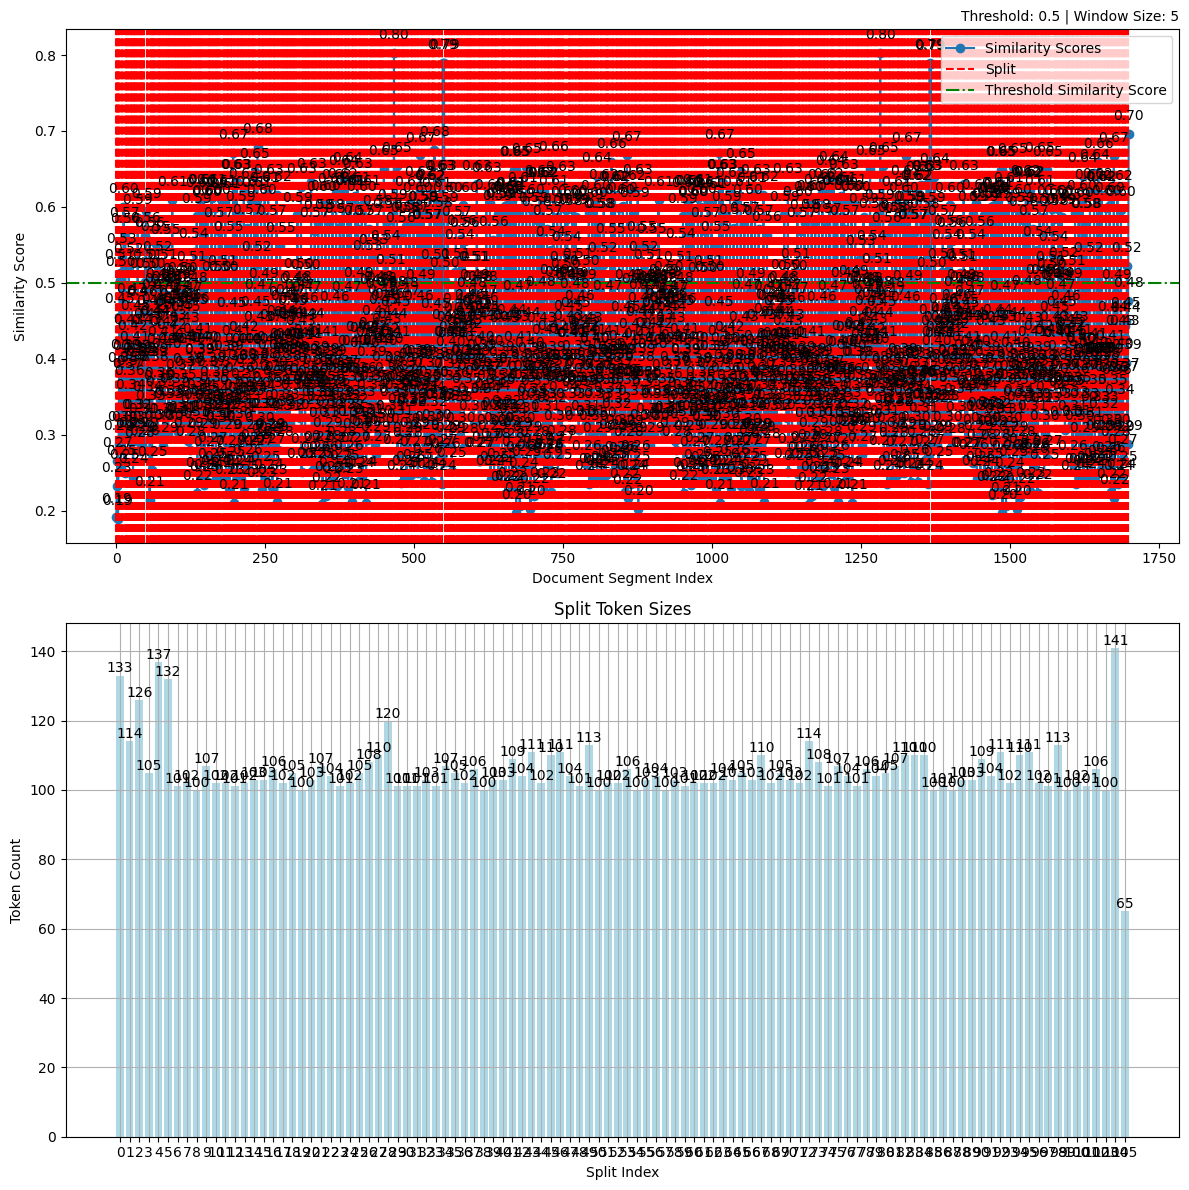

Splitting Statistics:
  - Total Documents: 1701
  - Total Splits: 106
  - Splits by Threshold: 105
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 65
  - Maximum Token Size of Split: 141
  - Similarity Split Ratio: 0.99
section_10.txt


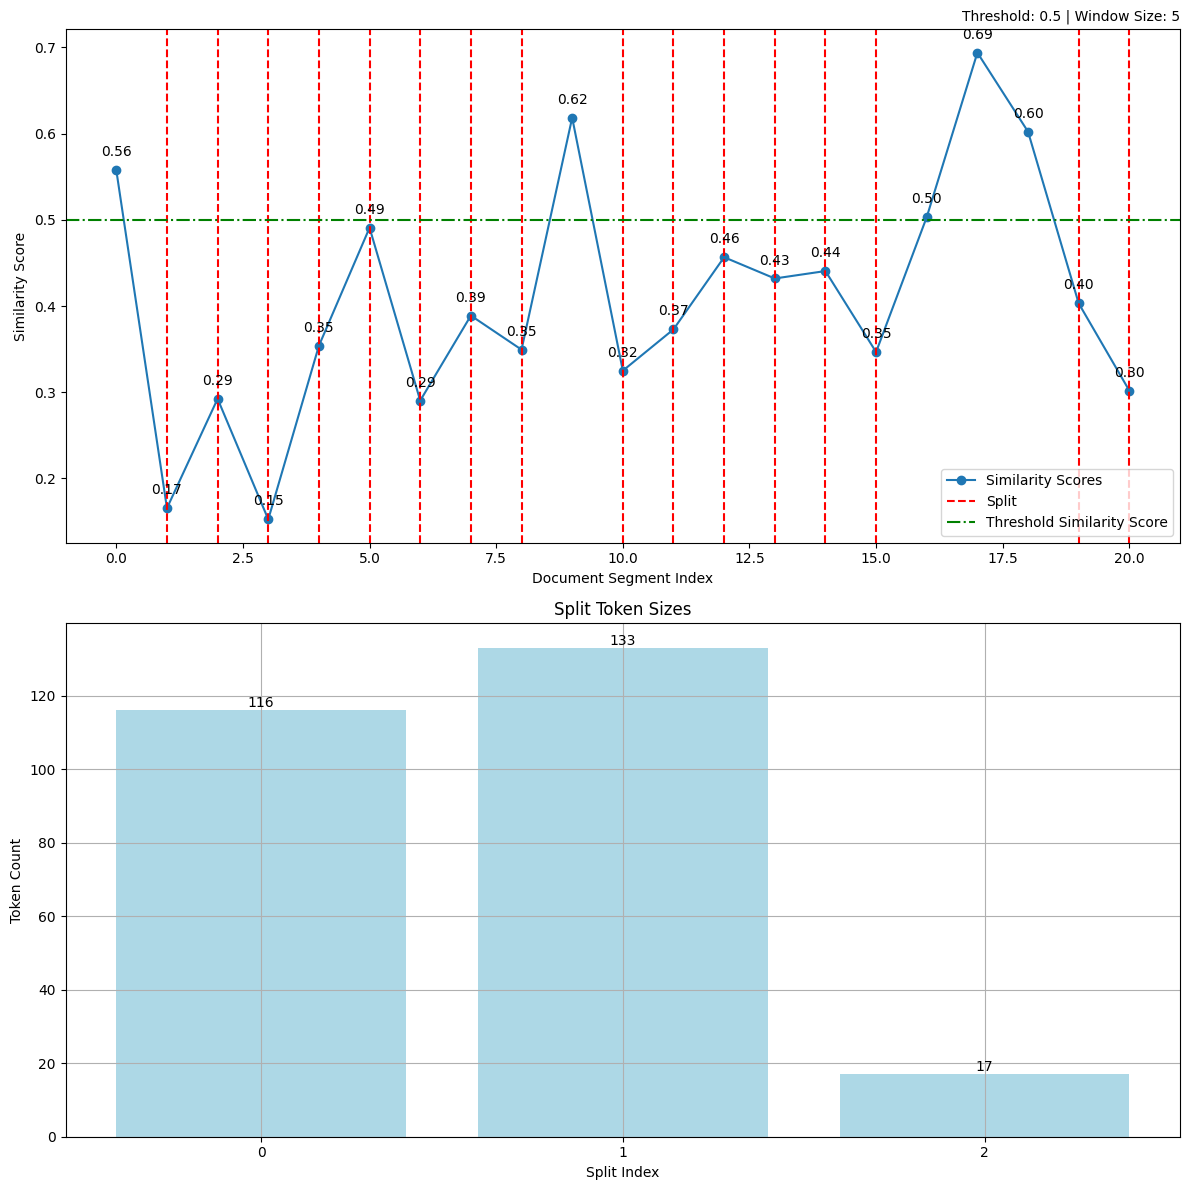

Splitting Statistics:
  - Total Documents: 22
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 17
  - Maximum Token Size of Split: 133
  - Similarity Split Ratio: 0.67
section_122.txt


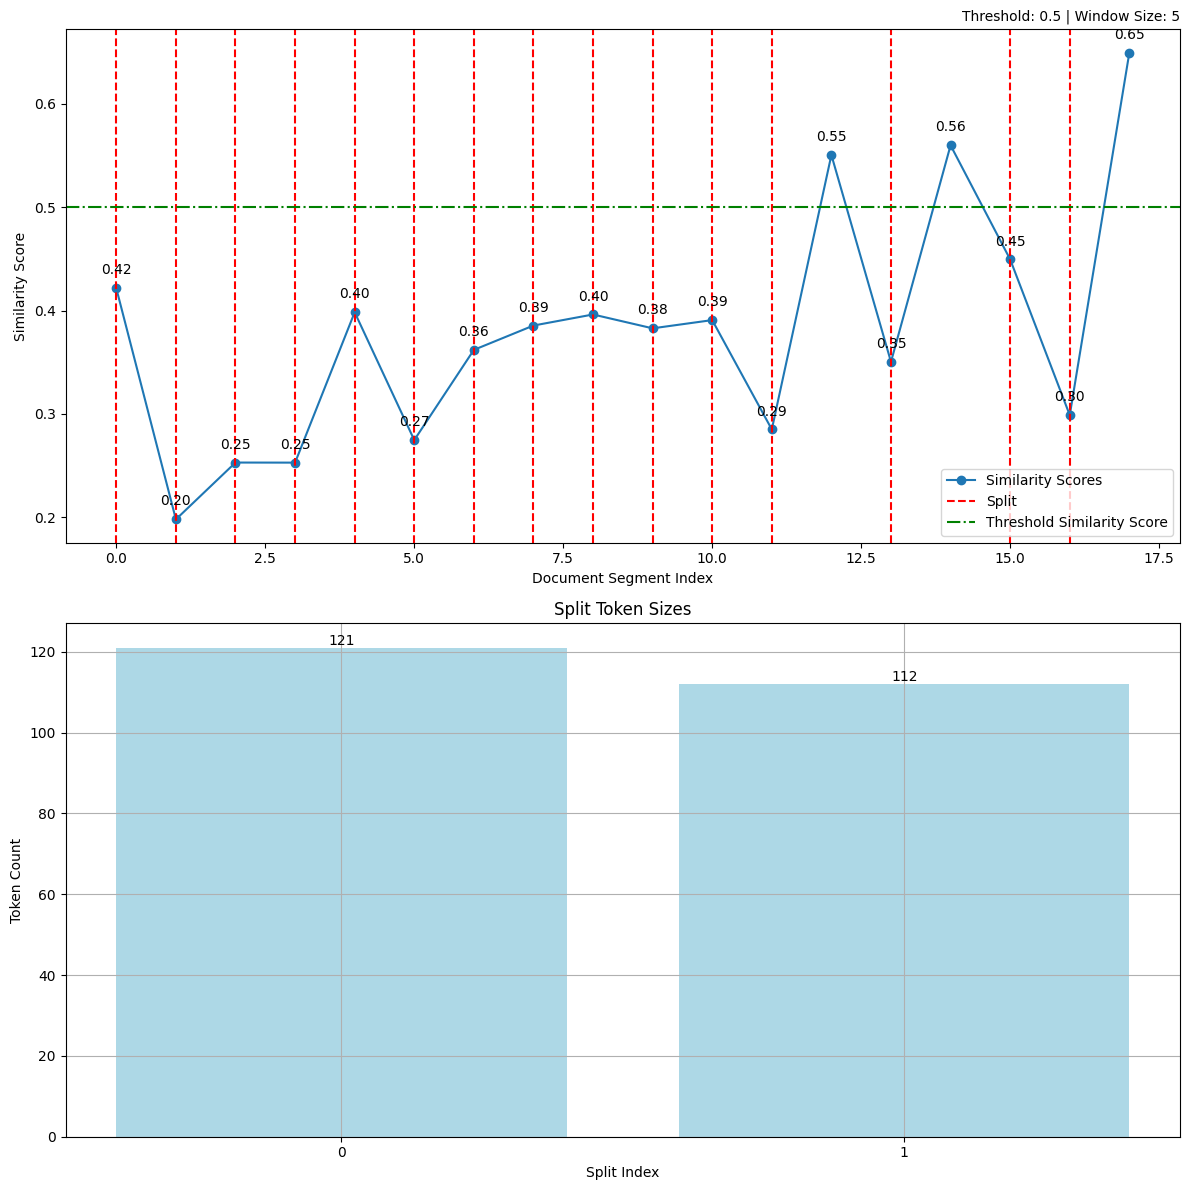

Splitting Statistics:
  - Total Documents: 19
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 112
  - Maximum Token Size of Split: 121
  - Similarity Split Ratio: 0.50
section_137.txt


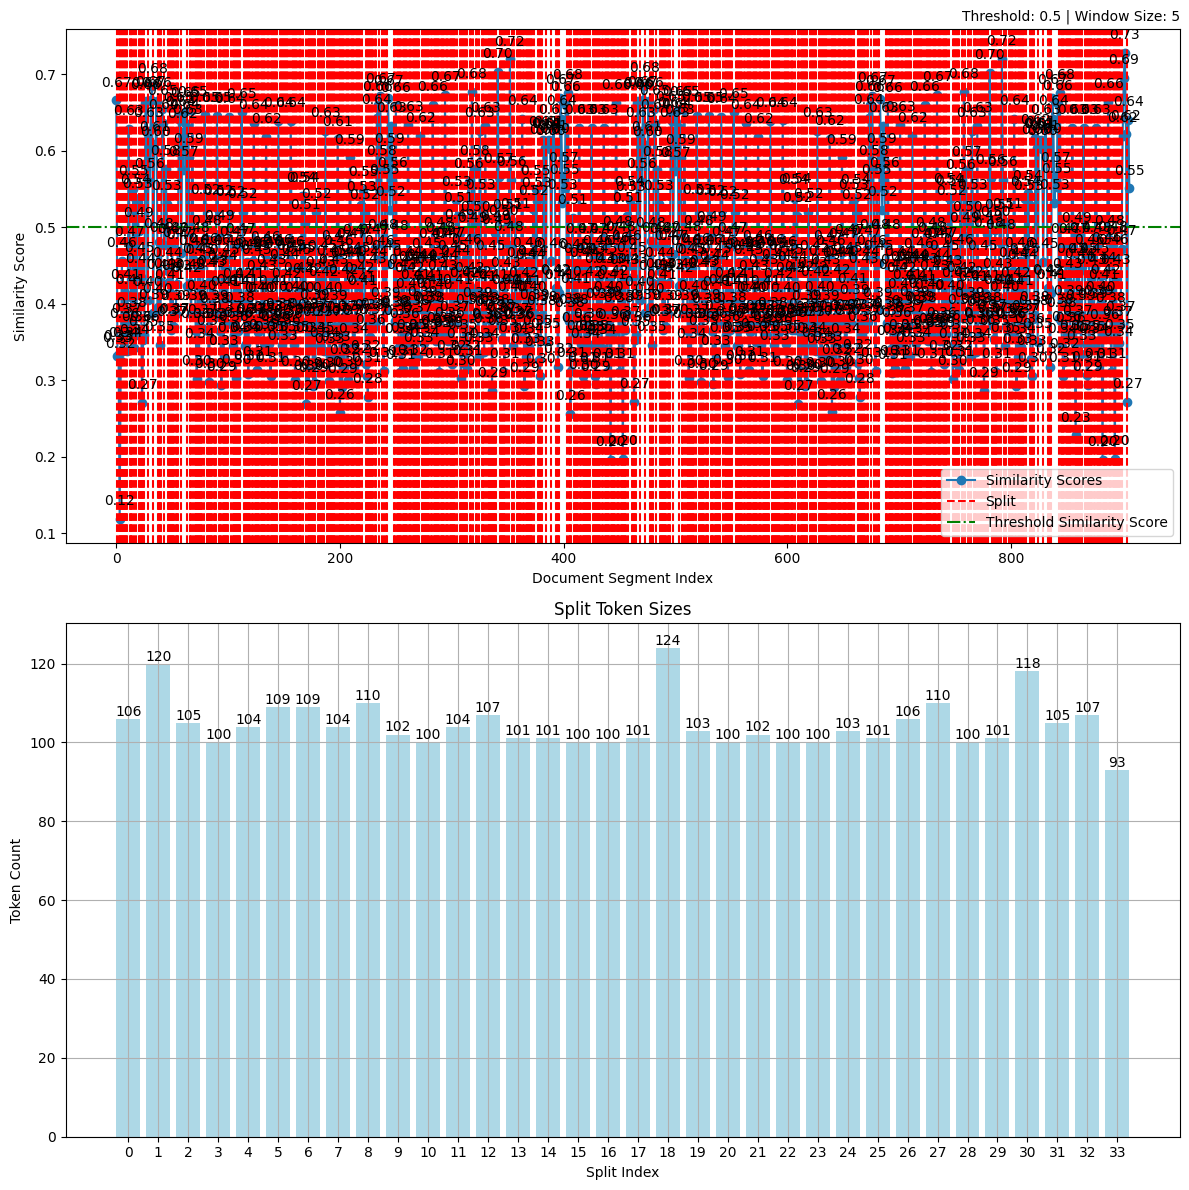

Splitting Statistics:
  - Total Documents: 908
  - Total Splits: 34
  - Splits by Threshold: 33
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 93
  - Maximum Token Size of Split: 124
  - Similarity Split Ratio: 0.97
section_32.txt


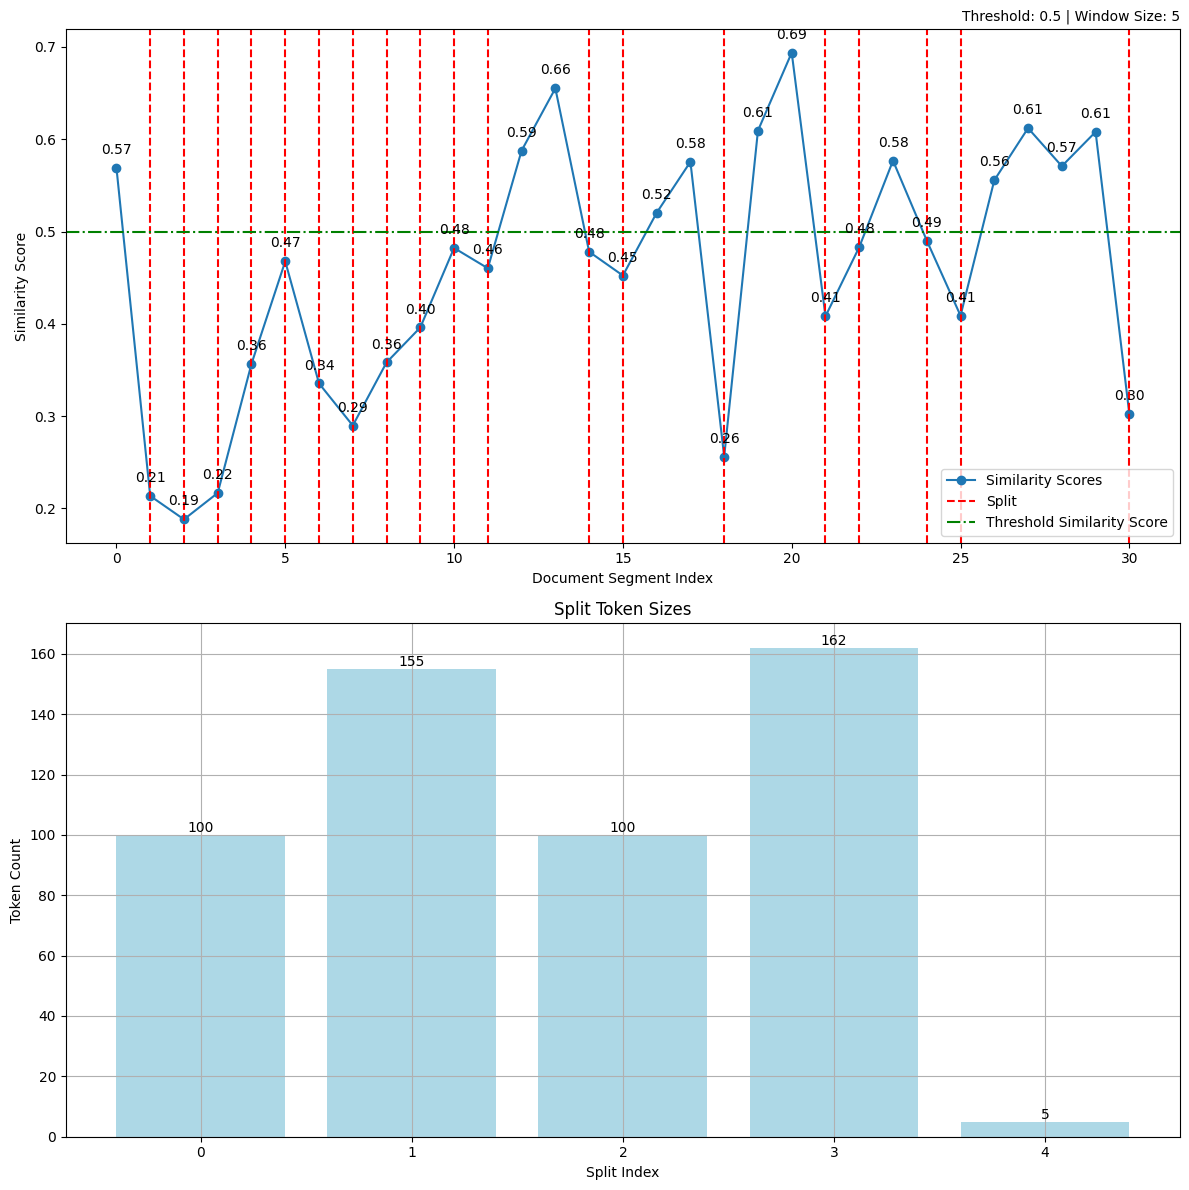

Splitting Statistics:
  - Total Documents: 32
  - Total Splits: 5
  - Splits by Threshold: 4
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 5
  - Maximum Token Size of Split: 162
  - Similarity Split Ratio: 0.80
section_34.txt


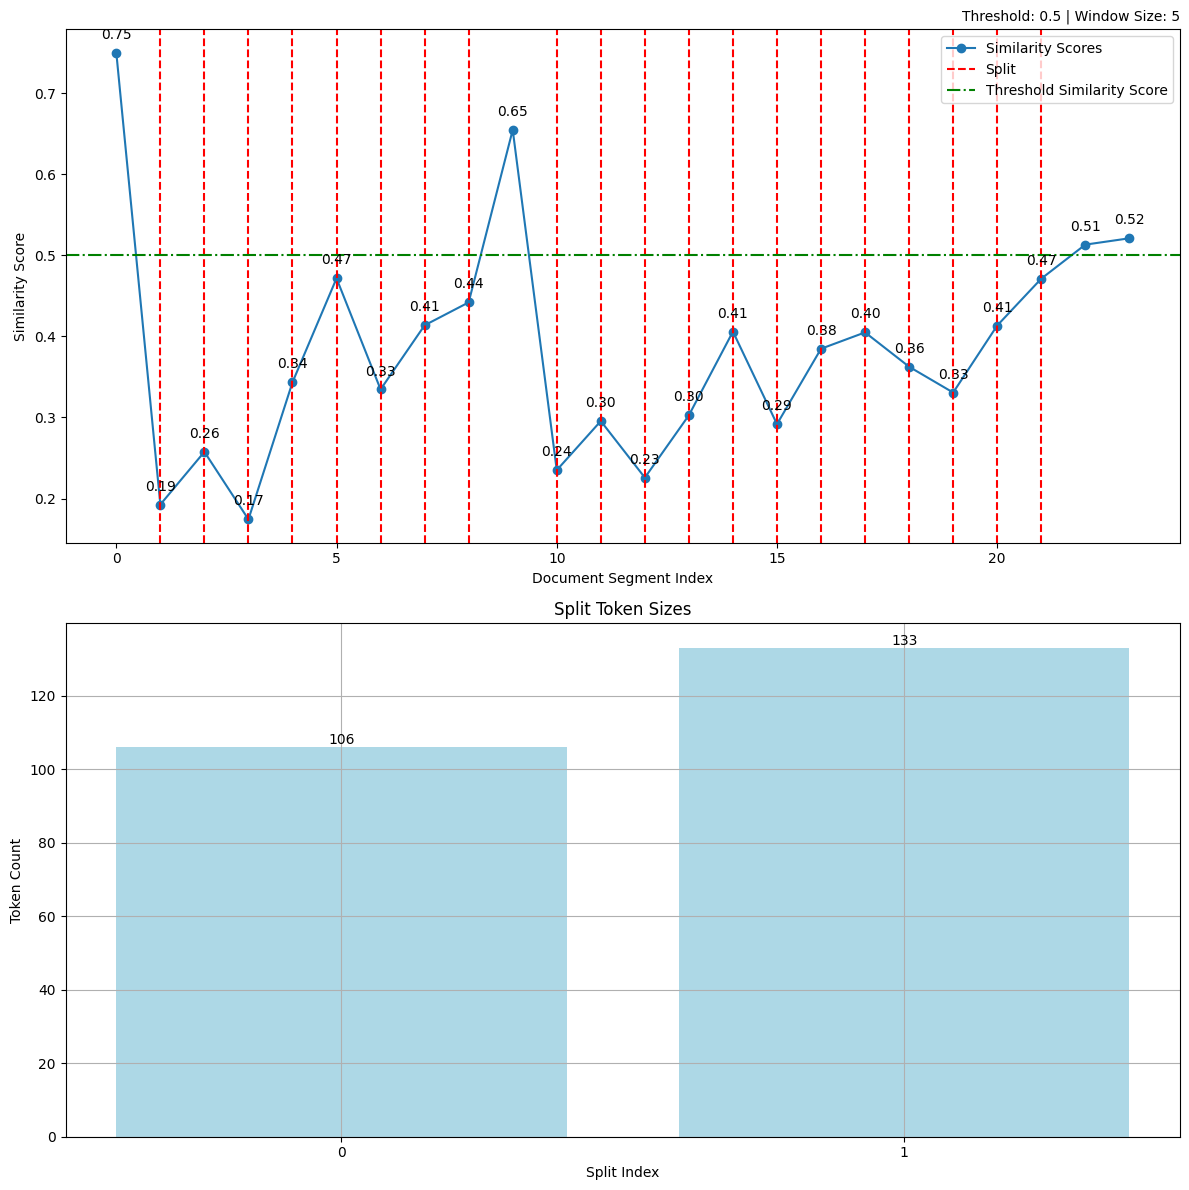

Splitting Statistics:
  - Total Documents: 25
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 106
  - Maximum Token Size of Split: 133
  - Similarity Split Ratio: 0.50
section_171.txt


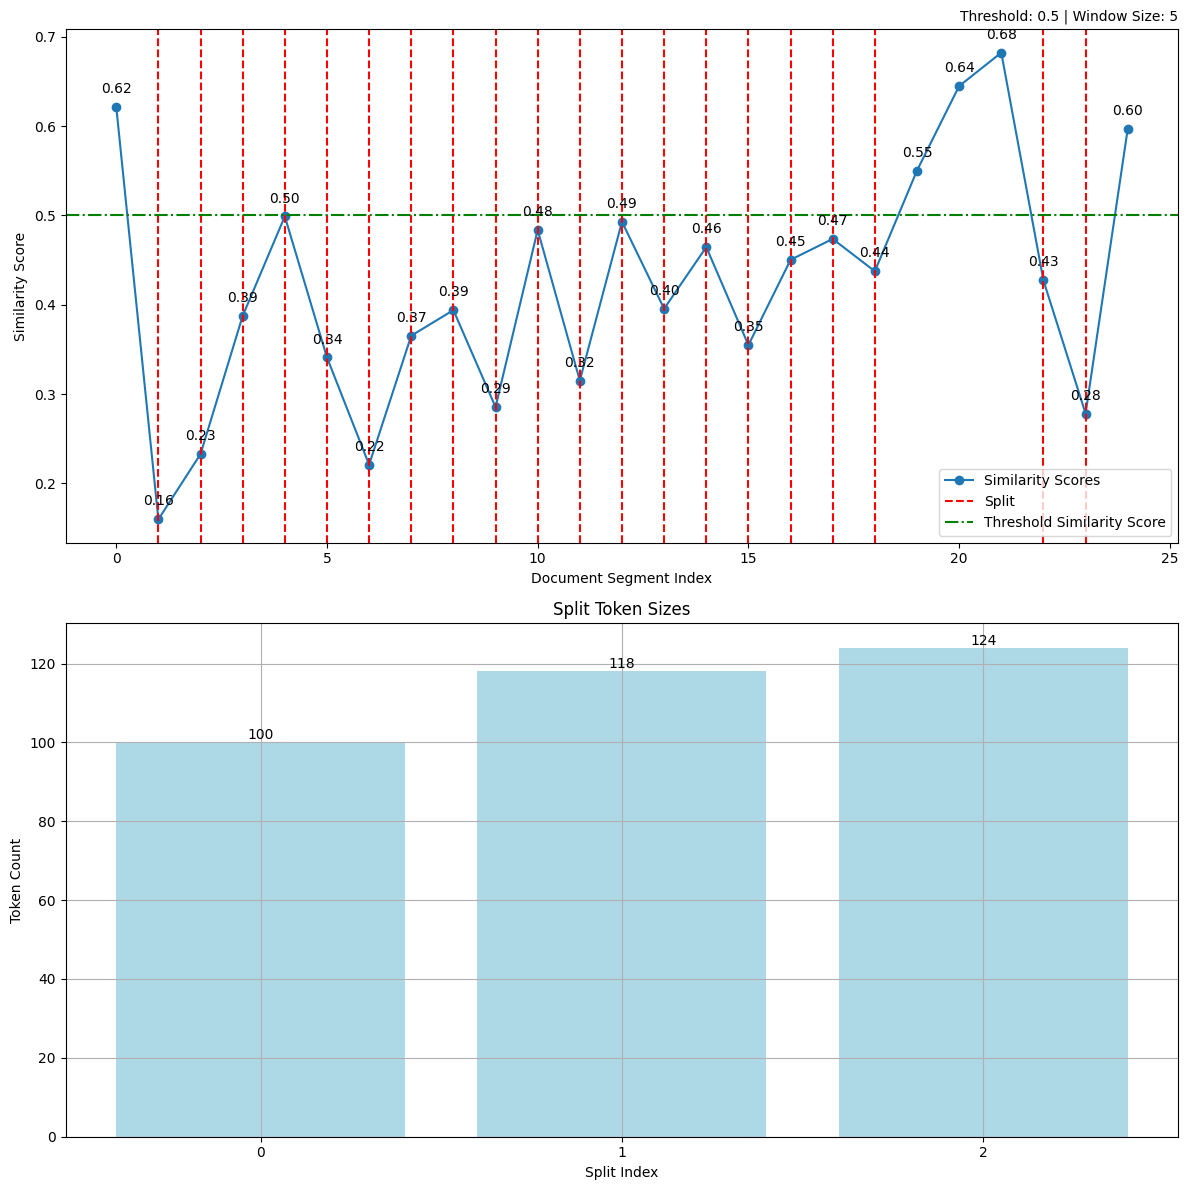

Splitting Statistics:
  - Total Documents: 26
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 100
  - Maximum Token Size of Split: 124
  - Similarity Split Ratio: 0.67
section_87.txt


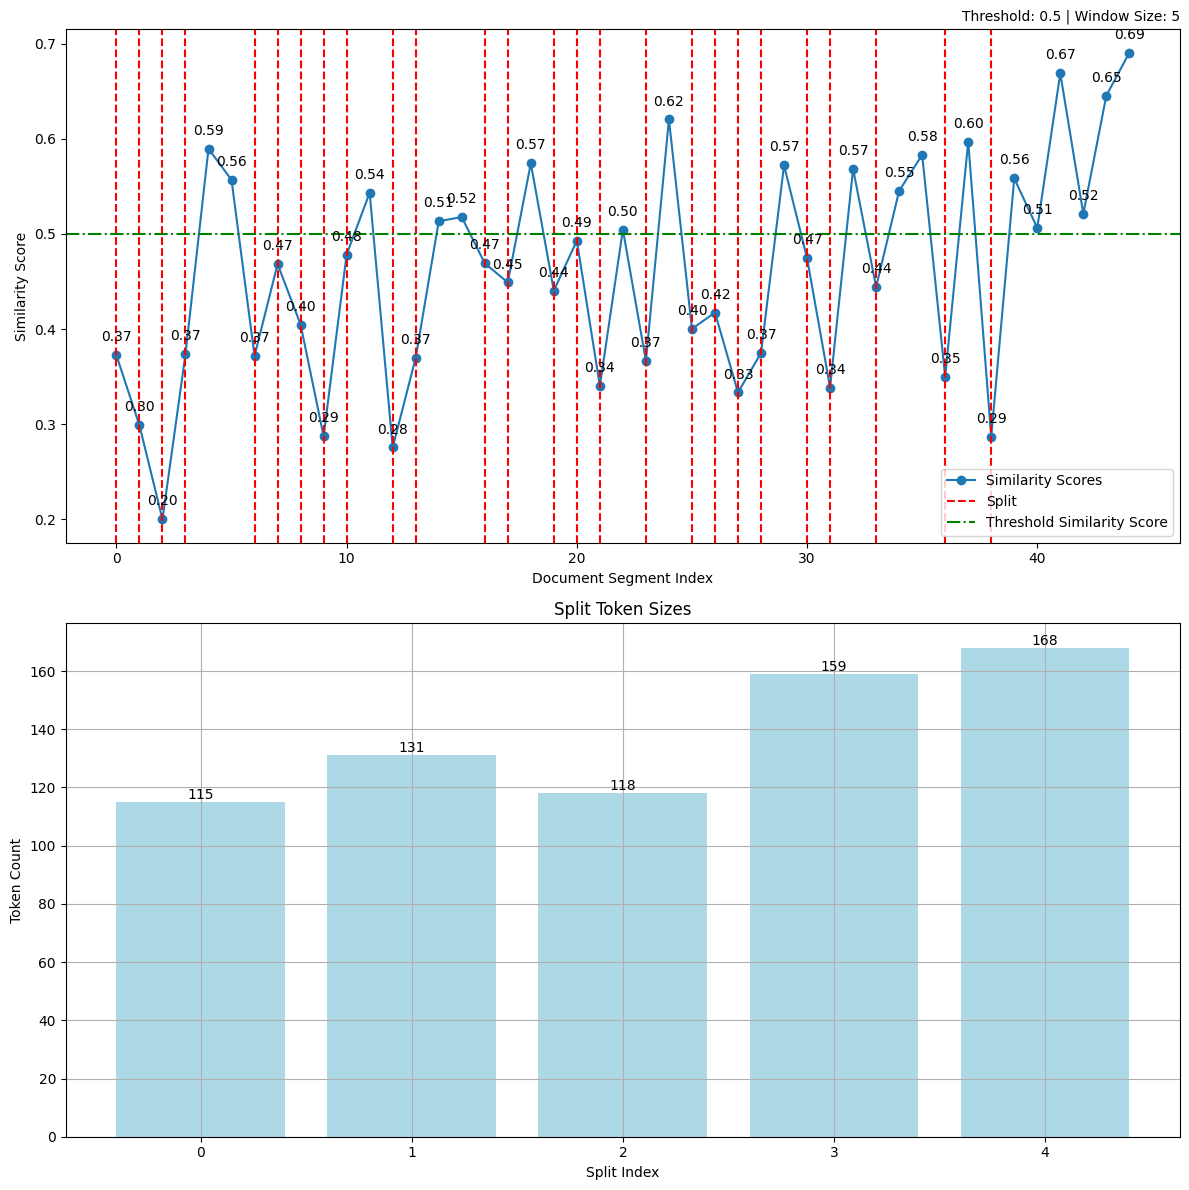

Splitting Statistics:
  - Total Documents: 46
  - Total Splits: 5
  - Splits by Threshold: 4
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 115
  - Maximum Token Size of Split: 168
  - Similarity Split Ratio: 0.80
section_229.txt


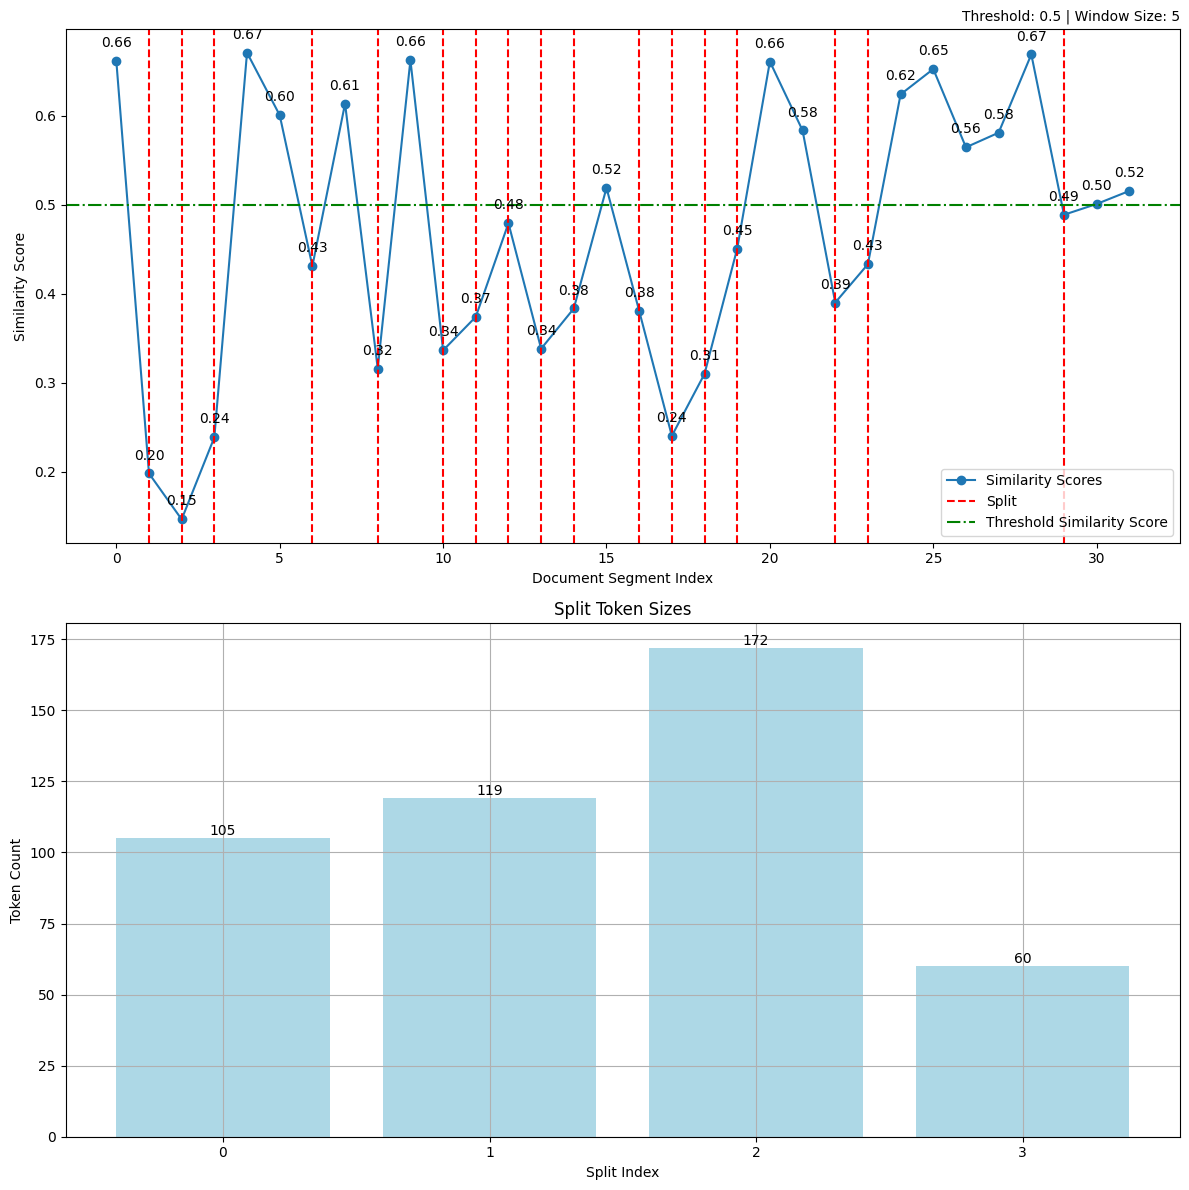

Splitting Statistics:
  - Total Documents: 33
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 60
  - Maximum Token Size of Split: 172
  - Similarity Split Ratio: 0.75
section_176.txt


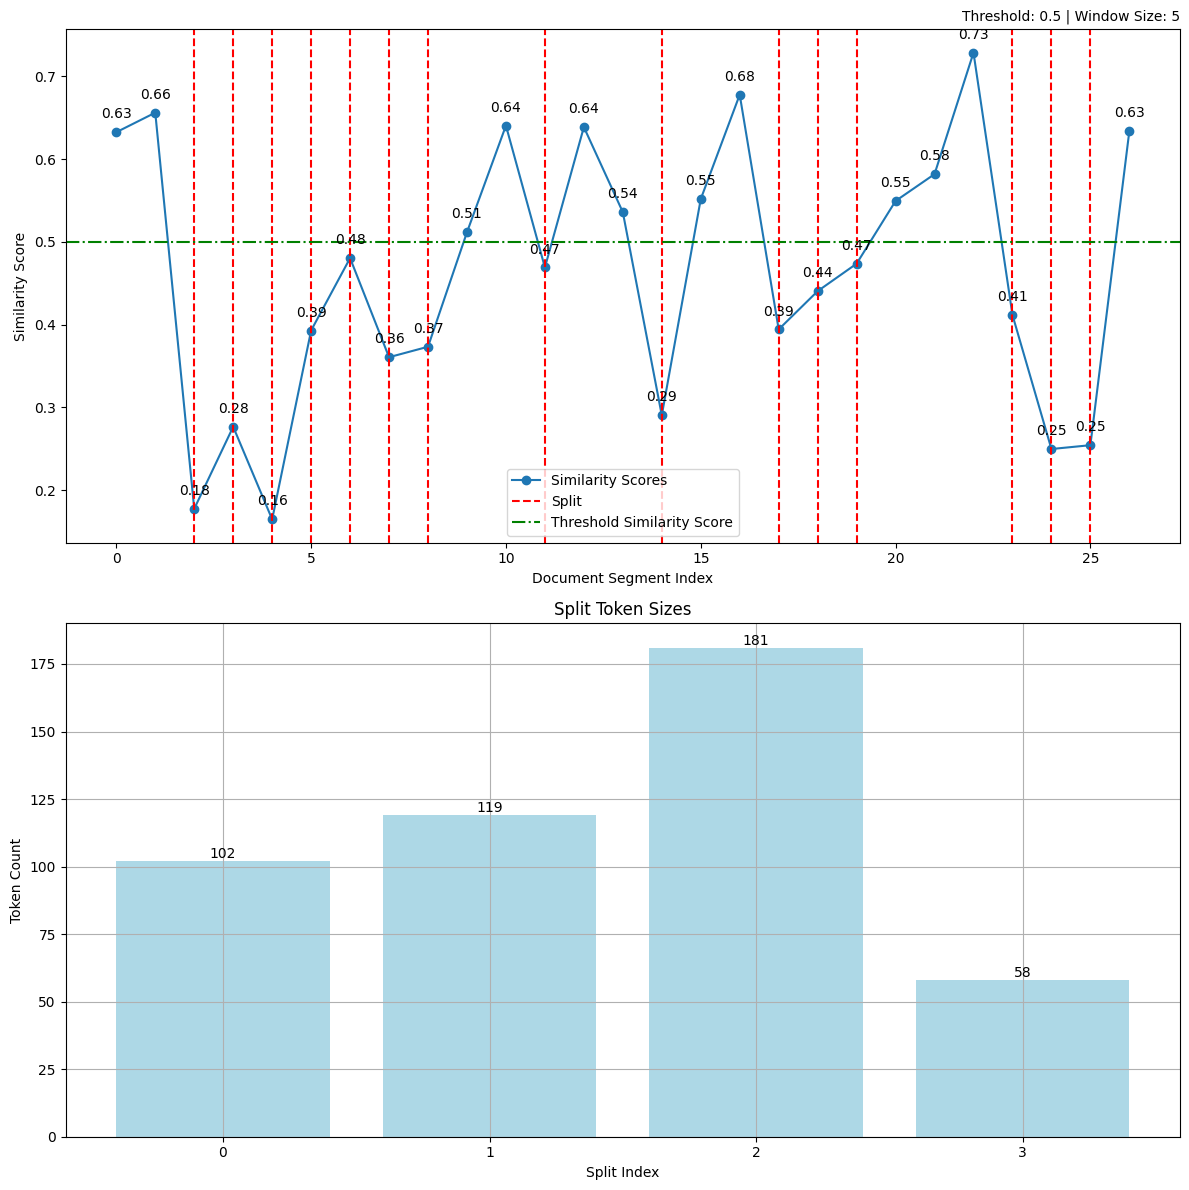

Splitting Statistics:
  - Total Documents: 28
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 58
  - Maximum Token Size of Split: 181
  - Similarity Split Ratio: 0.75
section_161.txt


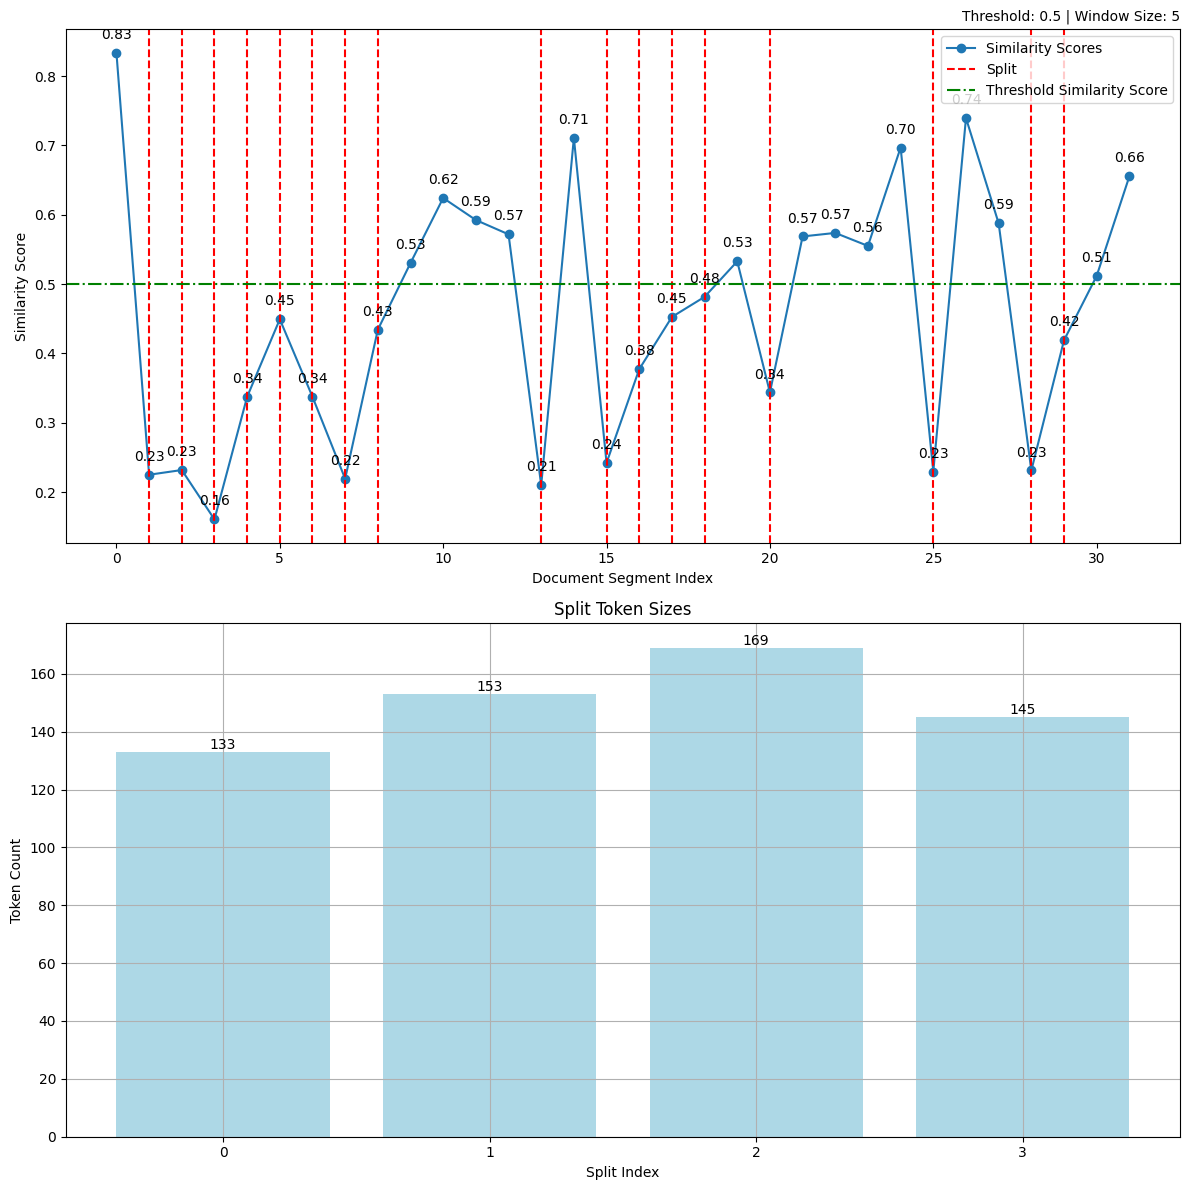

Splitting Statistics:
  - Total Documents: 33
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 133
  - Maximum Token Size of Split: 169
  - Similarity Split Ratio: 0.75


InsertManyResult([ObjectId('6714d62959be40a379e53985'), ObjectId('6714d62959be40a379e53986'), ObjectId('6714d62959be40a379e53987'), ObjectId('6714d62959be40a379e53988'), ObjectId('6714d62959be40a379e53989'), ObjectId('6714d62959be40a379e5398a'), ObjectId('6714d62959be40a379e5398b'), ObjectId('6714d62959be40a379e5398c'), ObjectId('6714d62959be40a379e5398d'), ObjectId('6714d62959be40a379e5398e'), ObjectId('6714d62959be40a379e5398f'), ObjectId('6714d62959be40a379e53990'), ObjectId('6714d62959be40a379e53991'), ObjectId('6714d62959be40a379e53992'), ObjectId('6714d62959be40a379e53993'), ObjectId('6714d62959be40a379e53994'), ObjectId('6714d62959be40a379e53995'), ObjectId('6714d62959be40a379e53996'), ObjectId('6714d62959be40a379e53997'), ObjectId('6714d62959be40a379e53998'), ObjectId('6714d62959be40a379e53999'), ObjectId('6714d62959be40a379e5399a'), ObjectId('6714d62959be40a379e5399b'), ObjectId('6714d62959be40a379e5399c'), ObjectId('6714d62959be40a379e5399d'), ObjectId('6714d62959be40a379e539

In [9]:
chunks = create_chunks(CohereEncoder(), 'data/docs', 0.5, 'models/text-embedding-004')
handler.update('embeddings', chunks)